# End2end ConvGRU

> Autoencoder + forecaster in the same training loop. Based on (https://github.com/tcapelle/moving_mnist/blob/master/01_train_example.ipynb) and (https://github.com/tcapelle/moving_mnist/blob/master/02_train_cross_entropy_loss-Copy1.ipynb)

In [1]:
import sys
sys.path.append('..')
from fastai.vision.all import *
from mocatml.utils import *
convert_uuids_to_indices()
from mocatml.data import *
from mocatml.models.conv_rnn import *
from mygrad import sliding_window_view
from tsai.imports import my_setup
from tsai.utils import yaml2dict, dict2attrdict
from fastai.callback.schedule import valley, steep
from fastai.callback.wandb import WandbCallback
import wandb

In [2]:
from fastai.callback.schedule import LRFinder

@patch_to(LRFinder)
def after_fit(self):
    self.learn.opt.zero_grad() # Needed before detaching the optimizer for future fits
    tmp_f = self.path/self.model_dir/self.tmp_p/'_tmp.pth'
    if tmp_f.exists():
        self.learn.load(f'{self.tmp_p}/_tmp', with_opt=True, device='cpu')
        self.tmp_d.cleanup()

In [3]:
my_setup()

os              : Linux-5.10.197-llgrid-x86_64-with-glibc2.35
python          : 3.9.15
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
torch           : 1.13.1+cu116
device          : 1 gpu (['Tesla V100-PCIE-32GB'])
cpu cores       : 40
threads per cpu : 2
RAM             : 377.57 GB
GPU memory      : N/A


In [4]:
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_base.convgru = yaml2dict('./config/convgru/convgru.yaml', attrdict=True)
#config = AttrDict({**config_base, **config_e2e})
config = AttrDict(config_base)
config

```json
{ 'bs': 32,
  'convgru': { 'attn': False,
               'blur': False,
               'coord_conv': False,
               'debug': False,
               'ks': 3,
               'n_in': 1,
               'n_out': 1,
               'norm': None,
               'rnn_ks': 5,
               'strategy': 'zero',
               'szs': [16, 64, 96]},
  'data': {'path': '~/arclab_shared/mc_density_data/comb_am_rp.npy'},
  'device': 'cuda',
  'horizon': 2,
  'lookback': 2,
  'lr_max': 0.001,
  'mmap': True,
  'n_epoch': 1,
  'normalize': True,
  'num_workers': 0,
  'save_learner': False,
  'seed': 42,
  'sel_steps': 20,
  'stride': 2,
  'tmp_folder': 'tmp',
  'wandb': { 'dir': None,
             'enabled': False,
             'group': None,
             'log_learner': False,
             'mode': 'offline',
             'project': 'mocatml'}}
```

In [5]:
# Set device
default_device(0 if config.device == 'cpu' else config.device)

device(type='cuda', index=0)

In [6]:
run = wandb.init(dir=ifnone(config.wandb.dir, '../'),
                 project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config
print(config)

{'bs': 32, 'data': {'path': '~/arclab_shared/mc_density_data/comb_am_rp.npy'}, 'device': 'cuda', 'horizon': 2, 'lr_max': 0.001, 'lookback': 2, 'mmap': True, 'n_epoch': 1, 'normalize': True, 'num_workers': 0, 'seed': 42, 'save_learner': False, 'sel_steps': 20, 'stride': 2, 'tmp_folder': 'tmp', 'wandb': {'dir': None, 'enabled': False, 'log_learner': False, 'mode': 'offline', 'group': None, 'project': 'mocatml'}, 'convgru': {'n_in': 1, 'n_out': 1, 'szs': [16, 64, 96], 'ks': 3, 'rnn_ks': 5, 'blur': False, 'attn': False, 'norm': None, 'strategy': 'zero', 'coord_conv': False, 'debug': False}}


In [7]:
data = np.load(Path(config.data.path).expanduser(), 
               mmap_mode='c' if config.mmap else None)
data = data[:, :config.sel_steps]
data.shape

(100, 20, 36, 99)

In [8]:
data_sw = np.lib.stride_tricks.sliding_window_view(data, 
                                               config.lookback + config.horizon, 
                                               axis=1)[:,::config.stride,:]
samples_per_simulation = data_sw.shape[1]
data_sw = data_sw.transpose(0,1,4,2,3)
data_sw = data_sw.reshape(-1, *data_sw.shape[2:])
data_sw.shape

(900, 4, 36, 99)

Split and get Normalization statistics from training set (mean and standard deviation)

In [9]:
# Split by simulation
splits = RandomSplitter()(data)
splits

((#80) [8,76,7,54,17,77,61,32,56,58...],
 (#20) [31,93,42,4,55,28,22,83,37,43...])

In [10]:
ds = DensityData(data_sw, lbk=config.lookback, h=config.horizon)
train_idxs = calculate_sample_idxs(splits[0], samples_per_simulation)
valid_idxs = calculate_sample_idxs(splits[1], samples_per_simulation)
len(train_idxs), len(valid_idxs)

(720, 180)

In [11]:
mocat_stats = (np.mean(data[splits[0]]), np.std(data[splits[0]]))
mocat_stats

(62.26685167648709, 182.4152935857871)

In [12]:
# Create dataloaders
train_tl = TfmdLists(train_idxs, DensityTupleTransform(ds))
valid_tl = TfmdLists(valid_idxs, DensityTupleTransform(ds))
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=config.bs, device=default_device(),
                            after_batch=[Normalize.from_stats(*mocat_stats)] if \
                             config.normalize else None,
                            num_workers=config.num_workers)
#dls.show_batch()
foo, bar = dls.one_batch()
len(foo), len(bar)

(2, 2)

In [13]:
#loss_func = StackLoss(MSELossFlat())
loss_func = PartialStackLoss([0], loss_func=MSELossFlat()) # Only care about first output
full_loss = StackLoss()
full_loss.__name__ = "full_loss"
metrics = [full_loss] # [StackLoss()]

In [14]:
config.convgru.norm = NormType.Batch if config.convgru.norm == 'batch' else None
model = StackUnstack(SimpleModel(**config.convgru)).to(default_device())
wandbc = WandbCallback(log_preds=False, log_model=False) if config.wandb.enabled else None
cbs = L() + wandbc
learn = Learner(dls, model, loss_func=loss_func, cbs=cbs, metrics=metrics)
learn.splits = splits # This is needed for the evaluation notebook
lr_max = config.lr_max if config.lr_max is not None else learn.lr_find()

In [15]:
learn.fit_one_cycle(config.n_epoch, lr_max=lr_max)

epoch,train_loss,valid_loss,full_loss,time
0,35964.386719,35110.195312,35159.328125,00:02


In [16]:
p,t = learn.get_preds()
len(p), p[0].shape

(2, torch.Size([180, 1, 36, 99]))

In [17]:
def show_res(t, idx, figsize=(8,4)):
    density_seq = DensitySeq.create([t[i][idx] for i in range(len(t))])
    density_seq.show(figsize=figsize);

146


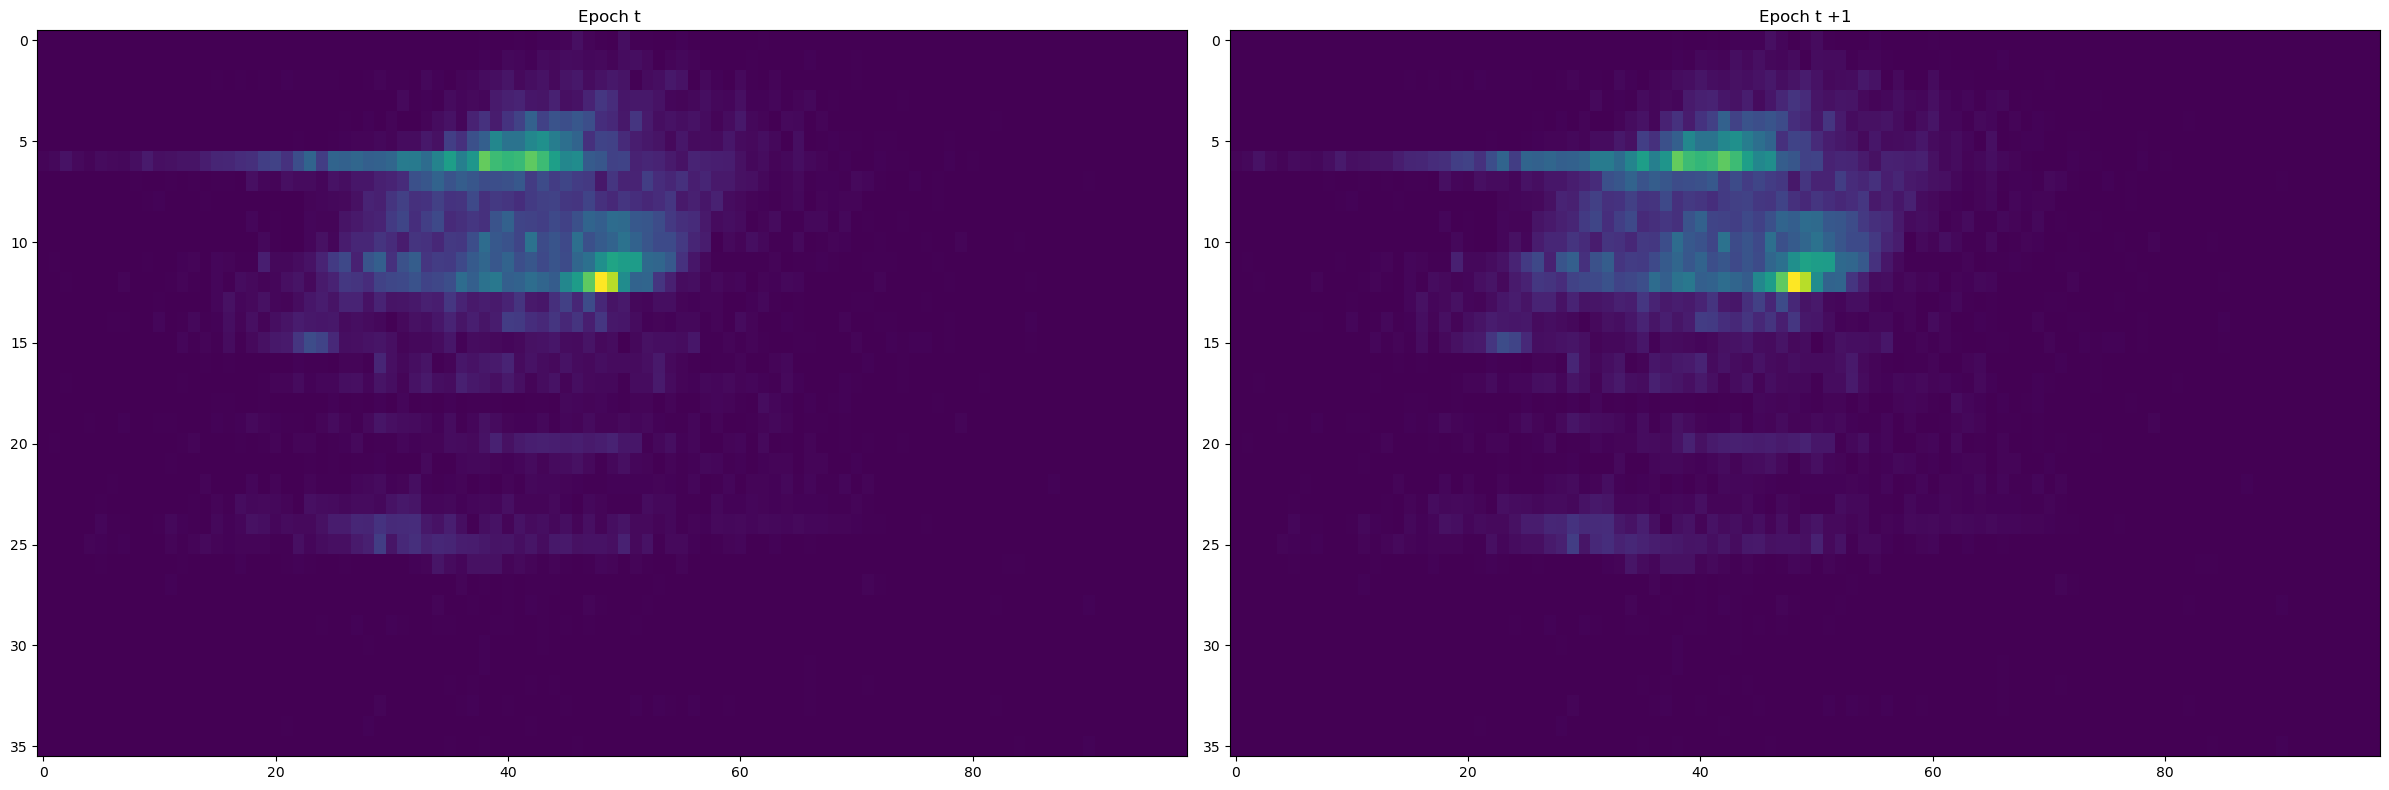

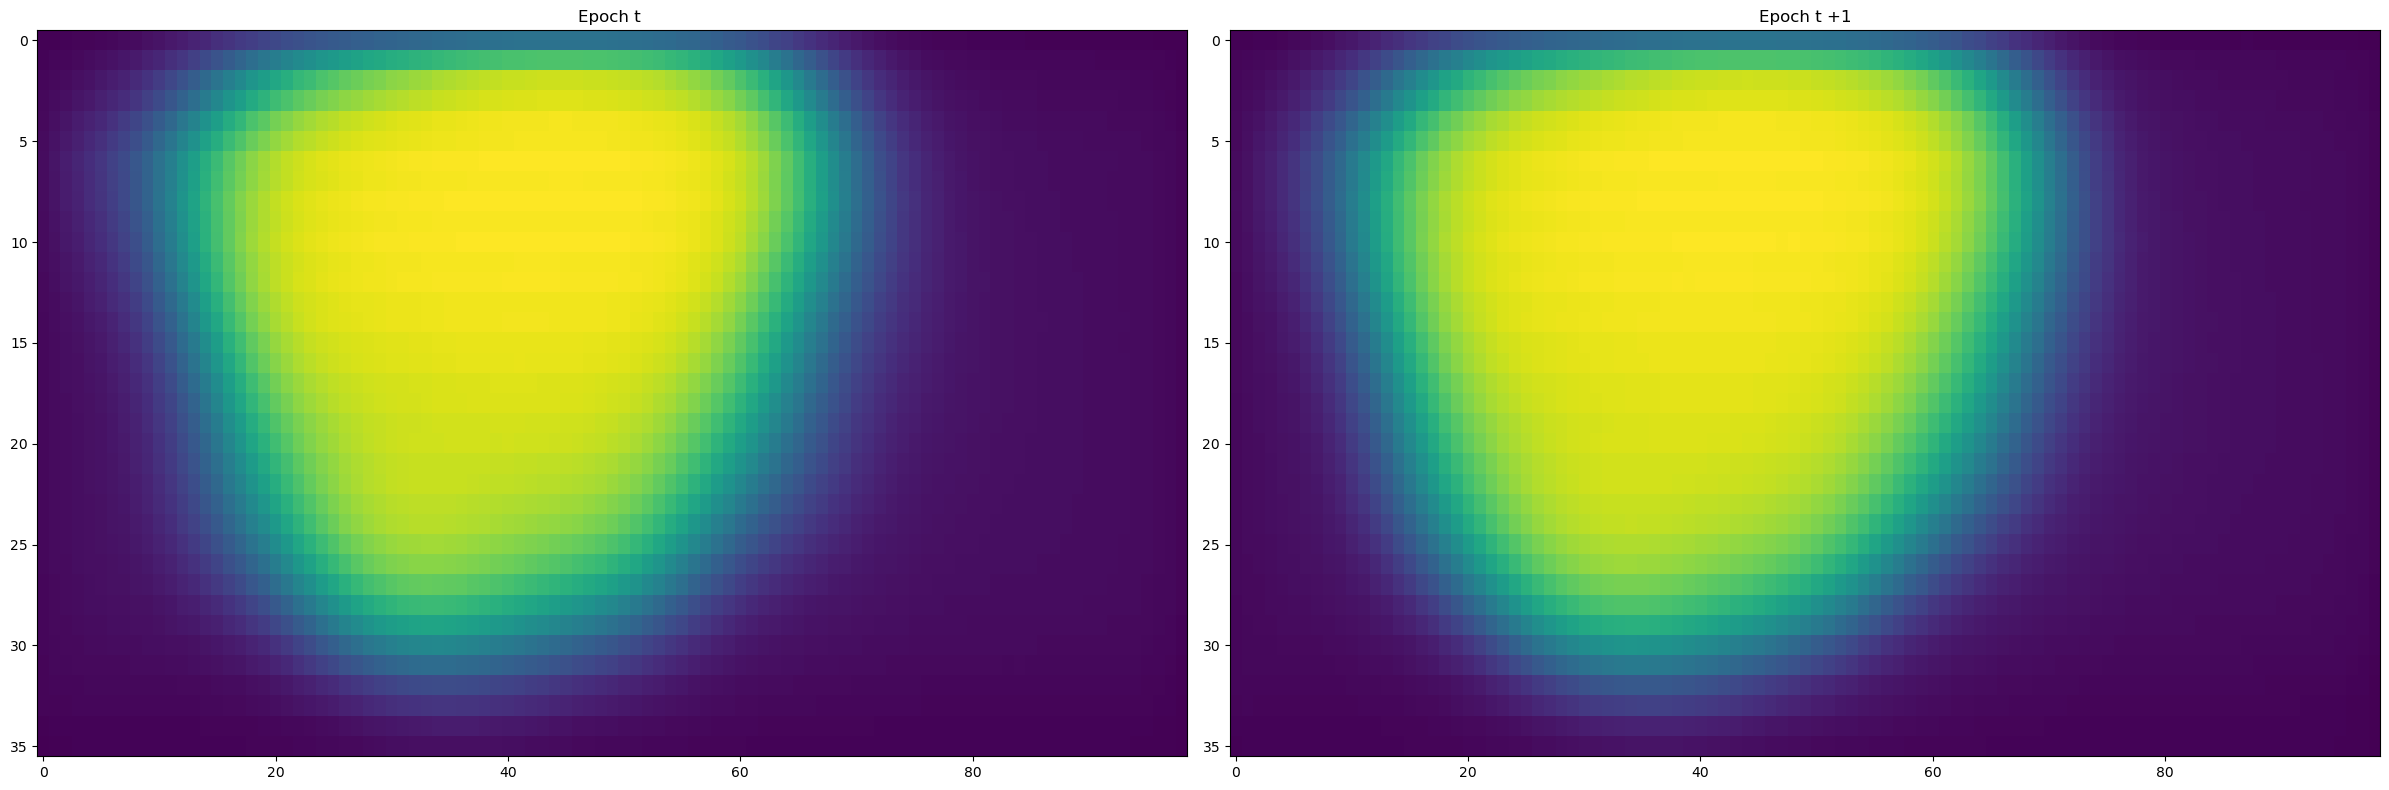

In [18]:
#|hide
k = random.randint(0, dls.valid.n)
figsize=(12,8)
print(k)
show_res(t,k, figsize=figsize)
show_res(p,k, figsize=figsize)

In [ ]:
# Log inference time
k = random.randint(0, dls.valid.n)
foo = TfmdLists([k], DensityTupleTransform(ds))
bar = dls.valid.new(foo)
start_time = time.time()
learn.get_preds(dl=bar)
wandb.log({'inference_time': time.time() - start_time})

In [19]:
#|hide
# Print the validation loss and save it in case other notebooks (optuna) wants to
# use it for hyperparameter optimization
valid_loss = learn.validate()[0] 
print(valid_loss)
%store valid_loss

35110.1953125
Stored 'valid_loss' (float)


In [34]:
#|hide
lss = learn.get_individual_losses(p, t)

In [20]:
# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learn.remove_cb(wandbc)

if config.save_learner:
    learn.model_dir = config.tmp_folder
    learn.export(f'{config.tmp_folder}/learner.pkl', pickle_protocol=4)

# Save locally and in wandb if it's enabled
if run is not None and config.wandb.log_learner:
    # Save the learner (all tmp/dls, tmp/model.pth, and tmp/learner.pkl). 
    run.log_artifact(config.tmp_folder, type='learner', name='density-forecaster')

In [21]:
if run is not None:
    run.finish()